In [1]:
import os
import xarray as xr
import dask
# from dask.diagnostics import ProgressBar
from progress import ProgressBar
import logging
import numpy as np

In [2]:
import hydra
from omegaconf import DictConfig
# 初始化 Hydra
hydra.initialize(config_path="conf", version_base=None)
# 组合配置
cfg = hydra.compose(config_name="config_uvsp_swh_mwp")
cfg

{'zarr_store_path': '/datasets/zarr_data_uvsp_swh_mwp', 'hdf5_store_path': '/datasets/hdf5_data_uvsp_swh_mwp_1', 'dt': 1, 'start_train_year': 1987, 'end_train_year': 2017, 'test_years': [2018, 2019], 'out_of_sample_years': [2020], 'compute_mean_std': False, 'variables': ['10m_u_component_of_wind', '10m_v_component_of_wind', 'surface_pressure', 'significant_height_of_combined_wind_waves_and_swell', 'mean_wave_period']}

In [3]:
	# Reformat the variables list so all elements are tuples
	reformated_variables = []
	for variable in cfg.variables:
		if isinstance(variable, str):
			reformated_variables.append(tuple([variable, None]))
		else:
			reformated_variables.append(variable)

In [4]:
	# Return the Zarr paths
	zarr_paths = []
	for variable, pressure_level in reformated_variables:
		zarr_path = f"{cfg.zarr_store_path}/{variable}.zarr"
		zarr_paths.append(zarr_path)

In [5]:
	# Check that Zarr arrays have correct dt for time dimension
	for zarr_path in zarr_paths:
		ds = xr.open_zarr(zarr_path)
		time_stamps = ds.time.values
		dt = time_stamps[1:] - time_stamps[:-1]
		assert np.all(
			dt == dt[0]
		), f"Zarr array {zarr_path} has incorrect dt for time dimension. An error may have occurred during download. Please delete the Zarr array and try again."

/usr/local/lib/python3.10/dist-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


In [6]:
zarr_arrays = [xr.open_zarr(path) for path in zarr_paths]
zarr_arrays

[<xarray.Dataset> Size: 66GB
 Dimensions:    (latitude: 165, longitude: 169, time: 298056)
 Coordinates:
   * latitude   (latitude) float32 660B 42.0 41.75 41.5 41.25 ... 1.5 1.25 1.0
   * longitude  (longitude) float32 676B 98.0 98.25 98.5 ... 139.5 139.8 140.0
   * time       (time) datetime64[ns] 2MB 1987-01-01 ... 2020-12-31T23:00:00
 Data variables:
     u10        (time, latitude, longitude) float64 66GB dask.array<chunksize=(1, 165, 169), meta=np.ndarray>
 Attributes:
     Conventions:  CF-1.6
     history:      2024-08-02 05:38:04 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...,
 <xarray.Dataset> Size: 66GB
 Dimensions:    (latitude: 165, longitude: 169, time: 298056)
 Coordinates:
   * latitude   (latitude) float32 660B 42.0 41.75 41.5 41.25 ... 1.5 1.25 1.0
   * longitude  (longitude) float32 676B 98.0 98.25 98.5 ... 139.5 139.8 140.0
   * time       (time) datetime64[ns] 2MB 1987-01-01 ... 2020-12-31T23:00:00
 Data variables:
     v10        (time, latitude, longitude) float64 66

In [7]:
zarr_arrays[3].sel(time='2015-09-27T04:00:00').swh.values



array([[       nan,        nan,        nan, ..., 0.76640769, 0.62203068,
               nan],
       [       nan,        nan,        nan, ..., 0.76874578, 0.70982593,
        0.64658062],
       [       nan,        nan,        nan, ..., 0.75845819, 0.69287479,
        0.61349666],
       ...,
       [0.47379583, 0.32591169,        nan, ..., 1.03552176, 1.04569245,
        1.05107005],
       [0.46724918, 0.48653842,        nan, ..., 1.02312989, 1.02920892,
        1.03026106],
       [0.53119592, 0.609405  ,        nan, ..., 1.01611562, 1.01868752,
        1.01973966]])

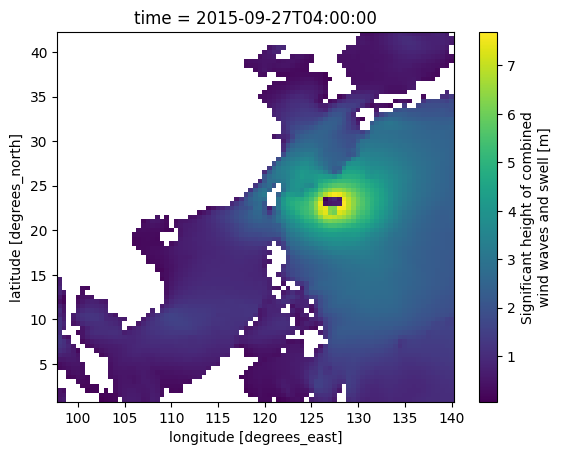

In [8]:
zarr_arrays[3].sel(time='2015-09-27T04:00:00').swh.plot()

In [9]:

	era5_xarray = xr.concat(
		[z[list(z.data_vars.keys())[0]] for z in zarr_arrays], dim="channel"
	)
	era5_xarray = era5_xarray.transpose("time", "channel", "latitude", "longitude")
	era5_xarray.name = "fields"
	era5_xarray = era5_xarray.astype("float32")

In [10]:
era5_xarray['latitude']

<xarray.DataArray 'latitude' (latitude: 165)> Size: 660B
array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,
        3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,
        6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75,
       11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75,
       16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25,
       18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75,
       21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25,
       23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75,
       26.  , 26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25,
       28.5 , 28.75, 29.  , 29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75,
       31.  , 31.25, 31.5 , 31.75, 32.  , 32.25, 32.5 , 32.75, 33.  , 33.25,
       33.5 , 33.75, 34.  , 34.25, 34.5 , 34.75, 35.  , 35.25, 35.5 , 35.75,
       36.  , 36.25, 36.5 , 36.75, 37.  , 37.25, 37.5 , 37.75, 38.  , 38.25,
       38.5 , 38.75, 39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75,
       41.  , 41.25, 41.5 , 41.75, 42.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 660B 1.0 1.25 1.5 1.75 ... 41.5 41.75 42.0
Attributes:
    long_name:  latitude
    units:      degrees_north

In [11]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=3)

<xarray.DataArray 'fields' (latitude: 165, longitude: 169)> Size: 112kB
dask.array<getitem, shape=(165, 169), dtype=float32, chunksize=(165, 169), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 660B 1.0 1.25 1.5 1.75 ... 41.5 41.75 42.0
  * longitude  (longitude) float32 676B 98.0 98.25 98.5 ... 139.5 139.8 140.0
    time       datetime64[ns] 8B 2015-09-27T04:00:00
Attributes:
    long_name:  10 metre U wind component
    units:      m s**-1

In [12]:
temp = era5_xarray.sel(time='2015-09-27T04:00:00',channel=3).values

In [13]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=3).values[2,:]

array([0.46724918,        nan, 0.4865384 ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.13863075,        nan,
       0.15511428,        nan, 0.15908903,        nan, 0.19427727,
              nan, 0.4158112 ,        nan, 0.56018823,        nan,
       0.6076514 ,        nan, 0.6076514 ,        nan, 0.5750351 ,
              nan, 0.483382  ,        nan, 0.5260521 ,        nan,
       0.62892807,        nan, 0.57877606,        nan, 0.32053408,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [14]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=3).values[:,1].shape

(165,)

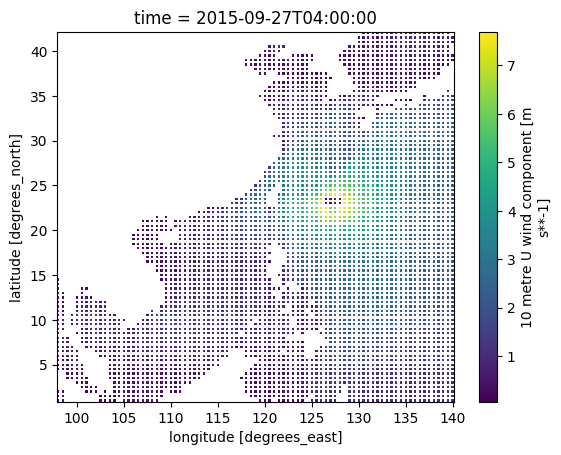

In [15]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=3).plot()

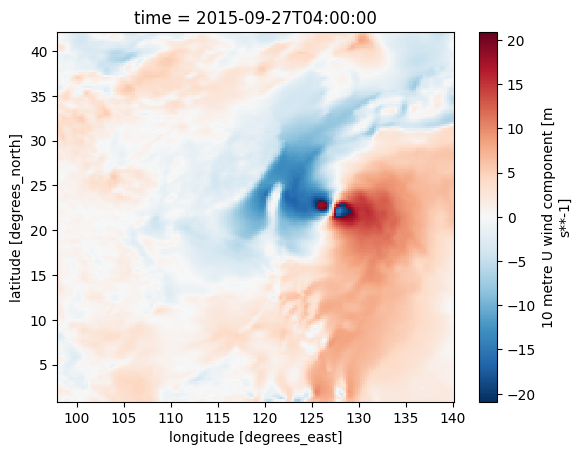

In [16]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=1).plot()

In [14]:
[
	np.nanmax(era5_xarray.sel(time='2015-09-27T04:00:00',channel=3)),
	np.nanmin(era5_xarray.sel(time='2015-09-27T04:00:00',channel=3)),
	np.nanmean(era5_xarray.sel(time='2015-09-27T04:00:00',channel=3)),
]

[7.690659, 0.05703143, 1.7251927]

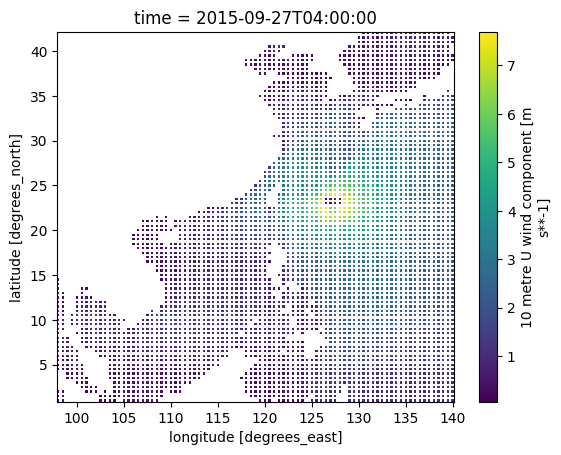

In [13]:
era5_xarray.sel(time='2015-09-27T04:00:00',channel=3).plot()

In [10]:
			era5_mean = np.array(
				era5_xarray.mean(dim=("time", "latitude", "longitude")).values
				)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f815c2c4be0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
